# NICE with tf==2.4.1 & tfp==0.12.1


### Paper: https://arxiv.org/pdf/1410.8516.pdf
### Implementation inspiration: https://github.com/DakshIdnani/pytorch-nice

## Import modules

In [1]:
from os import path
import numpy as np 
import pandas as pd

import tensorflow as tf 
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Load data

In [3]:
data_path = "mnist_784.csv"

In [4]:
if path.exists(data_path):
    data = pd.read_csv(data_path)
    X, y = data.iloc[:,:-1].values/255, data.iloc[:,-1].values/255
    X, y = X+np.random.uniform(0,1/256,(X.shape[0],X.shape[1])), y+np.random.uniform(0,1/256,y.shape)
else:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    X, y = X/255, y.astype(np.float)/255
    X, y = X+np.random.uniform(0,1/256,(X.shape[0],X.shape[1])), y+np.random.uniform(0,1/256,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

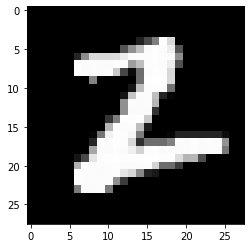

In [5]:
plt.imshow(X_train[0,:].reshape(28,28),cmap='gray')
plt.show()

## Model

In [6]:
class ScaleLayer(tf.keras.layers.Layer):
    """Layer that performs scaling."""
    def __init__(self,dim):
        super(ScaleLayer, self).__init__()
        w_init = tf.ones_initializer()
        self.S = tf.Variable(
            initial_value=w_init(shape=(dim), dtype="float32"),
            trainable=True,
        )

    def call(self, h,log_det_jacob=0, inverse=False):
        if inverse == True:
            y = tf.multiply(tf.math.exp(-self.S),h)
            return y
        h = tf.multiply(tf.math.exp(self.S),h)
        log_det_jacob = tf.math.reduce_sum(self.S)
        return h, log_det_jacob

In [7]:
class Linear(keras.layers.Layer):
    """y = w.x + b"""
    def __init__(self,name,units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(name + "_weight",
                               shape=[input_dim, units],
                               regularizer=tf.keras.regularizers.l1_l2(.0001))
        self.b = self.add_weight(name + "_bias",
                               shape=[units],
                               regularizer=tf.keras.regularizers.l1_l2(.0001))

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [8]:
class AdditiveCouple(tf.keras.layers.Layer):
    def __init__(self,name, dim, mask,couple_dim):
        super(AdditiveCouple, self).__init__()
        
        self.dim = dim
        self.couple_dim = couple_dim
        self.mask = mask
        
        # Declare layers of NeuralNet~m
        self.l1 = Linear(name+'1',self.couple_dim,self.dim)
        self.l2 = Linear(name+'2',self.couple_dim,self.couple_dim)
        self.l3 = Linear(name+'3',self.dim,self.couple_dim)

    def m(self,x):
        x = self.l1(x)
        x = tf.nn.leaky_relu(x)
        x = self.l2(x)
        x = tf.nn.leaky_relu(x)
        x = self.l3(x)
        return x

    def call(self, x, inverse=False):
        if inverse == True:
            y1, y2 = self.mask*x, (1-self.mask)*x 
            x1, x2 = y1, y2-(self.m(y1)*(1-self.mask))
            return x1+x2
        else:
            x1, x2 = self.mask*x, (1-self.mask)*x
            y1, y2 = x1, x2+(self.m(x1)*(1-self.mask))
            return y1+y2

In [9]:
class NICE(keras.Model):
    def __init__(self,input_dim,n_couple, couple_dim,**kwargs):
        super(NICE, self).__init__(**kwargs)

        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.prior = tfp.distributions.Logistic(0,1)
        
        self.input_dim = input_dim
        self.n_couple = n_couple
        self.couple_dim = couple_dim

        masks = [self._get_mask(self.input_dim, orientation=(i % 2 == 0)) for i in range(self.n_couple)]
        
        # Declare coupling layers
        self.coupling_layers = []
        for i in range(self.n_couple-1):
            add_couple = AdditiveCouple(str(i) ,self.input_dim,masks[i],self.couple_dim)
            self.coupling_layers.append(add_couple)
        
        # Declare Scaling layer
        self.S = ScaleLayer(dim=input_dim)

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def _get_mask(self, dim, orientation=True):
        mask = np.zeros(dim)
        mask[::2] = 1.
        if orientation:
            mask = 1. - mask  # flip mask orientation
        return mask
        
    def train_step(self, data):
        X, y = data[0], data[1]
        with tf.GradientTape() as tape:
            # Feed input through model 
            h, s_vals = self(X)
            
            # Caculate loss, prior is standard logistic
            #loss = s_vals + tf.math.reduce_sum(self.prior.log_prob(h),axis=-1)
            #loss = s_vals - tf.math.reduce_sum(tf.math.log(tf.math.exp(h)+1)+tf.math.log(tf.math.exp(-1*h)+1),axis=-1)
            loss = s_vals + tf.reduce_sum(-(tf.math.softplus(h) + tf.math.softplus(-h)), axis=1)
            
            loss = -tf.math.reduce_mean(loss)
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {
            "log_likelihood": self.loss_tracker.result(),
        }

    def test_step(self, data):
        X, y = data[0], data[1]
        h, s_vals = self(X)
        #loss = s_vals + tf.math.reduce_sum(self.prior.log_prob(h),axis=1)
        #loss = s_vals - tf.math.reduce_sum(tf.math.log(tf.math.exp(h)+1)+tf.math.log(tf.math.exp(-1*h)+1),axis=-1)
        loss = s_vals + tf.reduce_sum(-(tf.math.softplus(h) + tf.math.softplus(-h)), axis=1)
        
        loss = -tf.math.reduce_mean(loss)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    def call(self,x,inverse=False,pass_inv=False):
        log_det_jacob = 0
        if inverse == True:
            if pass_inv == False:
                h = np.random.logistic(x,1, self.input_dim)
                h = np.reshape(h,(1,self.input_dim))
            elif pass_inv == True:
                h = x

            x = self.S(h,inverse=True)
            for layer in reversed(self.coupling_layers):
                x = layer(x,inverse=True)
            return x
        else:
            for layer in self.coupling_layers:
                x = layer(x)
            h, log_det_jacob = self.S(x,log_det_jacob)
            return h, log_det_jacob

## Fit model

In [10]:
opt = keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0)
model = NICE(input_dim=784,n_couple=5,couple_dim=1000)
model.compile(optimizer=opt)


In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),\
                    epochs=50, batch_size=256)

Epoch 1/50
129/129 [==============================] - 16s 107ms/step - log_likelihood: 324.3770 - val_loss: 220.7117
Epoch 2/50
129/129 [==============================] - 17s 134ms/step - log_likelihood: 193.9161 - val_loss: 118.0207
Epoch 3/50
129/129 [==============================] - 15s 113ms/step - log_likelihood: 91.9069 - val_loss: 18.4034
Epoch 4/50
129/129 [==============================] - 15s 119ms/step - log_likelihood: -8.0185 - val_loss: -80.2987
Epoch 5/50
129/129 [==============================] - 16s 126ms/step - log_likelihood: -106.9626 - val_loss: -177.7435
Epoch 6/50
129/129 [==============================] - 18s 136ms/step - log_likelihood: -204.7490 - val_loss: -273.9467
Epoch 7/50
129/129 [==============================] - 16s 124ms/step - log_likelihood: -301.7335 - val_loss: -368.9302
Epoch 8/50
129/129 [==============================] - 15s 113ms/step - log_likelihood: -397.4781 - val_loss: -462.4799
Epoch 9/50
129/129 [==============================] - 15s 1

In [12]:
model.save_weights("NICE_weights.h5")

## Sample Model

In [50]:
model = NICE(input_dim=784,n_couple=5,couple_dim=1000)
x = np.ones((1,784))
x = model(x, inverse=True, pass_inv=True)
model.load_weights("nice_weights.h5")
model.summary()

Model: "nice_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
additive_couple_11 (Additive multiple                  2570784   
_________________________________________________________________
additive_couple_12 (Additive multiple                  2570784   
_________________________________________________________________
additive_couple_13 (Additive multiple                  2570784   
_________________________________________________________________
additive_couple_14 (Additive multiple                  2570784   
_________________________________________________________________
scale_layer_3 (ScaleLayer)   multiple                  784       
Total params: 10,283,922
Trainable params: 10,283,920
Non-trainable params: 2
_________________________________________________________________


### Interpolation test

In [55]:
A, B  = X_train[0,:], X_train[1,:]

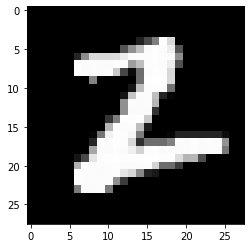

In [56]:
plt.imshow(A.reshape(28,28),cmap='gray')

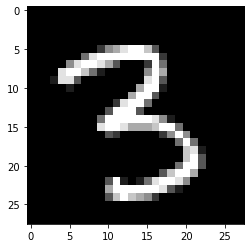

In [57]:
plt.imshow(B.reshape(28,28),cmap='gray')

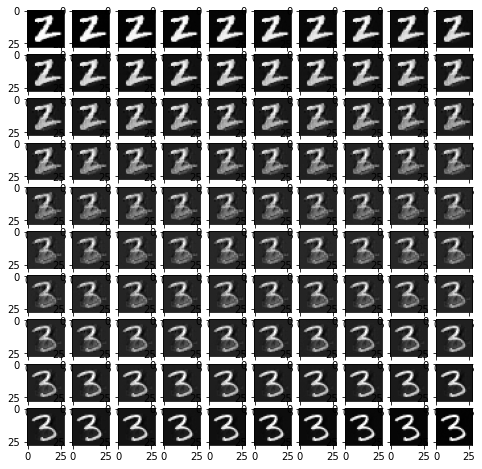

In [60]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 10

phi = 0 

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    mix_A_B = A*(1-phi)+B*phi
    
    a, _ = model(A.reshape(1,784), inverse=False)
    a = a.numpy()
    b, _ = model(B.reshape(1,784), inverse=False)
    b = b.numpy()
    mix_a_b = a*(1-phi)+b*phi
    img = model(mix_a_b, inverse=True, pass_inv=True).numpy()
    phi += .01
    
    plt.imshow(img.reshape(28,28), cmap="gray")
plt.show()

### Inverse test

In [36]:
sample = X_train[0,:]

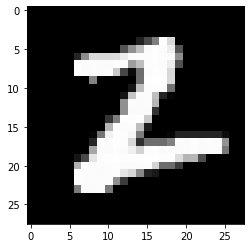

In [37]:
plt.imshow(sample.reshape(28,28),cmap='gray')

In [48]:
x, _ = model(sample.reshape(1,784), inverse=False)
x = x.numpy()
sample_xh = model(x.reshape(1,784), inverse=True, pass_inv=True).numpy()

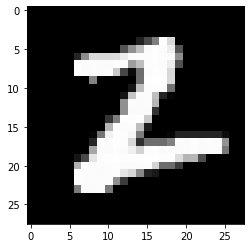

In [49]:
plt.imshow(sample_xh.reshape(28,28),cmap='gray')